In [1]:
import pandas as pd

PROBLEMA -> La precipitación solo va del 1991 al 2018

In [2]:
GBIF_DATA_PATH = 'GBIF/csv/'
file_name = 'assemblages_aggregated_by_grid_with_centroids.csv'
gbif_assemblages_1991_2020 = pd.read_csv(GBIF_DATA_PATH+file_name)

# Filter the gbif_assemblages DataFrame for years <= 2018
gbif_assemblages = gbif_assemblages_1991_2020[gbif_assemblages_1991_2020['year'] <= 2018]

gbif_assemblages

,grid_index,year,species,longitude,latitude
1,79231,2011,"['Angelica archangelica', 'Dactylorhiza majali...",5.172939,59.201189
2,79231,2012,"['Carex distans', 'Euphrasia foulaensis', 'Car...",5.172939,59.201189
3,79231,2014,"['Lysimachia europaea', 'Ficaria verna', 'Junc...",5.172939,59.201189
4,79231,2015,"['Tripolium pannonicum', 'Centaurium littorale...",5.172939,59.201189
5,79231,2016,"['Lysimachia europaea', 'Lythrum salicaria', '...",5.172939,59.201189
...,...,...,...,...,...
71740,1818627,2012,"['Avenella flexuosa', 'Lathyrus japonicus', 'H...",30.835603,69.774990
71741,1818627,2017,"['Luzula spicata', 'Antennaria dioica', 'Cochl...",30.835603,69.774990
71742,1820117,1994,"['Honckenya peploides', 'Alnus incana', 'Epilo...",30.847255,69.755439
71743,1821608,1994,"['Taraxacum spectabile', 'Astragalus norvegicu...",30.865522,69.744514


excluding the years 2019 and 2020 filters out 10.000 samples!!!!!

We will have to complement the preciptation of these years with some other model

### Function for reading Chelsa variables patch

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
# Load the NetCDF file
def read_netcdf(file_path,latitude,longitude,grid,location,variable = None):
    data = xr.open_dataset(file_path)
    
    # Step 1: Find the indices of the closest grid point
    lat_idx = np.argmin(np.abs(data['lat'].values - latitude))
    lon_idx = np.argmin(np.abs(data['lon'].values - longitude))
    
    # Step 2: Select all months of the year
    #precipitation= data.sel(**{"time": slice(1, 12)})

    # Extract variable name (it is always the last variable)
    variable = list(data.data_vars.keys())[-1]
    # Step 3: Extract a 10x10 grid centered around Bergen
    patch = data[variable].isel(
        lat=slice(lat_idx - grid, lat_idx + grid),
        lon=slice(lon_idx - grid, lon_idx + grid)
    )
    
    # Step 4: Calculate the mean precipitation across all months
    #mean_patch = patch.mean(dim="time")
    
    # Step 5: Plot with Cartopy for map context
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())  # PlateCarree assumes latitude/longitude
    
    # Plot the precipitation data
    # mean_patch.plot(ax=ax, cmap="Blues", transform=ccrs.PlateCarree(), add_colorbar=True)
    patch.plot(ax=ax, cmap="Blues", transform=ccrs.PlateCarree(), add_colorbar=True)
    
    # Add map features
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')  # Country borders
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')               # Coastline
    # ax.set_extent([mean_patch.lon.min(), mean_patch.lon.max(), mean_patch.lat.min(), mean_patch.lat.max()])
    ax.set_extent([patch.lon.min(), patch.lon.max(), patch.lat.min(), patch.lat.max()])

    
    # Add city marker for Bergen
    plt.scatter(longitude, latitude, color="red", label=location, transform=ccrs.PlateCarree())
    plt.legend()
    
    # Title and labels
    plt.title(f"{variable} in {location}, (10x10 grid)")
    plt.show()

    return patch

#### Usage example

In [5]:
# Load the NetCDF file

def load_NetCDF_file(path):
    data = xr.open_dataset(path)
    return data


In [6]:
path_prsd = "CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/prsd/CHELSA_EUR11_obs_prsd_1991_V.2.1.nc"
data_example = load_NetCDF_file(path_prsd)
data_example

<xarray.Dataset> Size: 320MB
Dimensions:    (time: 1, bnds: 2, lon: 13147, lat: 6077)
Coordinates:
  * time       (time) datetime64[ns] 8B 1991-07-02
  * lon        (lon) float64 105kB -44.64 -44.63 -44.62 ... 64.9 64.9 64.91
  * lat        (lat) float64 49kB 21.97 21.98 21.99 22.0 ... 72.59 72.6 72.6
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 16B ...
    crs        int32 4B ...
    pr         (time, lat, lon) float32 320MB ...
Attributes:
    CDI:                 Climate Data Interface version 1.9.9rc1 (https://mpi...
    Conventions:         CF-1.5
    history:             Mon Jan 30 17:44:41 2023: cdo -b 32 timstd /storage/...
    institution:         Swiss Federal Institute for Forest\
    GDAL_AREA_OR_POINT:  Area
    GDAL:                GDAL 2.2.3, released 2017/11/20
    title:               CHELSA V2.1
    project:             CHELSA - Climatologies at high resolution for the ea...
    contact:             Dirk N. Karger\
    references:          Karger DN. et al. Climatologies at high resolution f...
    doi:                 doi: 10.16904/envidat.228.v2.1
    CDO:                 Climate Data Operators version 1.9.9rc1 (https://mpi...

In [7]:
data_example['pr']
type(data_example.data_vars)
for i in data_example.data_vars:
    print(i)

time_bnds
crs
pr


In [8]:
list(data_example.data_vars.keys())[-1]

'pr'

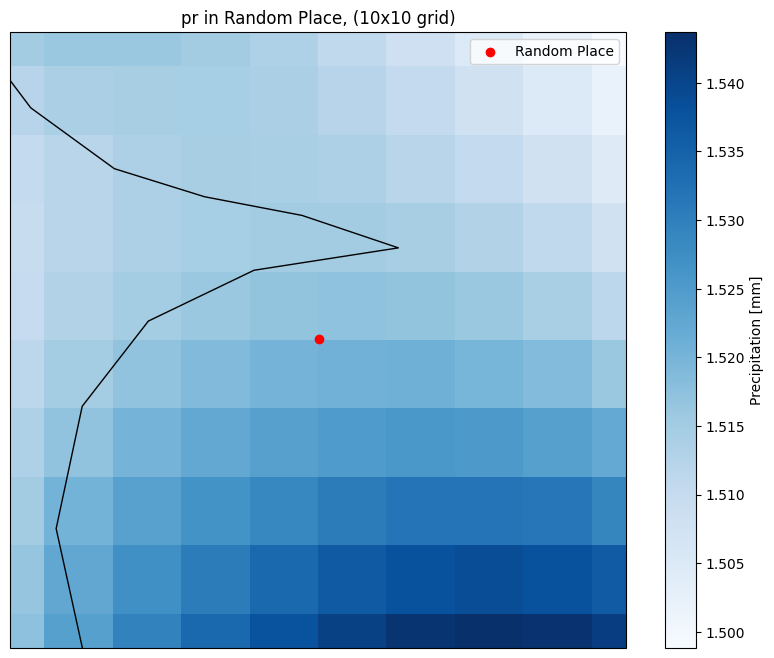

In [9]:
path_bio15d = "CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/bio15d/CHELSA_EUR11_obs_bio15d_2000_V.2.1.nc"

bio15d_2000 = read_netcdf(file_path = path_bio15d, #path_prsd,
            latitude = 62.9,
            longitude = 8.2,
            # variable = 'pr',
            grid = 5,
            location = 'Random Place')


In [10]:
bio15d_2000

<xarray.DataArray 'pr' (time: 1, lat: 10, lon: 10)> Size: 400B
[100 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 8B 2000-07-01
  * lon      (lon) float64 80B 8.162 8.171 8.179 8.187 ... 8.221 8.229 8.237
  * lat      (lat) float64 80B 62.86 62.87 62.88 62.89 ... 62.92 62.93 62.94
Attributes:
    standard_name:  precipitation
    long_name:      Precipitation
    units:          mm
    grid_mapping:   crs

### Reading All variables per Sample

In [11]:
import os

CHELSA_path = 'CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1'
# Scan the directory and get
# an iterator of os.DirEntry objects
# corresponding to entries in it
# using os.scandir() method
obj = os.scandir(CHELSA_path)

# List all files and directories in the specified path
print("Files and Directories in '% s':" % CHELSA_path)
variables = []
for entry in obj:
    if entry.is_dir():
        #print(entry.name)
        variables.append(entry.name)
variables

Files and Directories in 'CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1':


['gdd5',
 'prsd',
 'bio12d',
 'swe',
 'bio01d',
 'bio04d',
 'cdd',
 'fd',
 'bio15d',
 'scd']

In [12]:

for variable in variables:
    path = f"CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/{variable}/CHELSA_EUR11_obs_{variable}_1991_V.2.1.nc"
    data_climatic_variable = load_NetCDF_file(path)
    print(f"The data structure for {variable} is: \n")
    print(data_climatic_variable)
    print('-------------------------------------------------------------------------------------------')

The data structure for gdd5 is: 

<xarray.Dataset> Size: 320MB
Dimensions:    (time: 1, bnds: 2, lon: 13147, lat: 6077)
Coordinates:
  * time       (time) datetime64[ns] 8B 1991-07-02
  * lon        (lon) float64 105kB -44.64 -44.63 -44.62 ... 64.9 64.9 64.91
  * lat        (lat) float64 49kB 21.97 21.98 21.99 22.0 ... 72.59 72.6 72.6
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 16B ...
    crs        int32 4B ...
    tas        (time, lat, lon) float32 320MB ...
Attributes: (12/13)
    CDI:                 Climate Data Interface version 1.9.9rc1 (https://mpi...
    Conventions:         CF-1.5
    history:             Mon Jan 30 18:32:16 2023: cdo -b 32 timsum -max -sub...
    institution:         Swiss Federal Institute for Forest\
    GDAL_AREA_OR_POINT:  Area
    GDAL:                GDAL 2.2.3, released 2017/11/20
    ...                  ...
    project:             CHELSA - Climatologies at high resolution for the ea...
    conta

### Plotting 1 sample

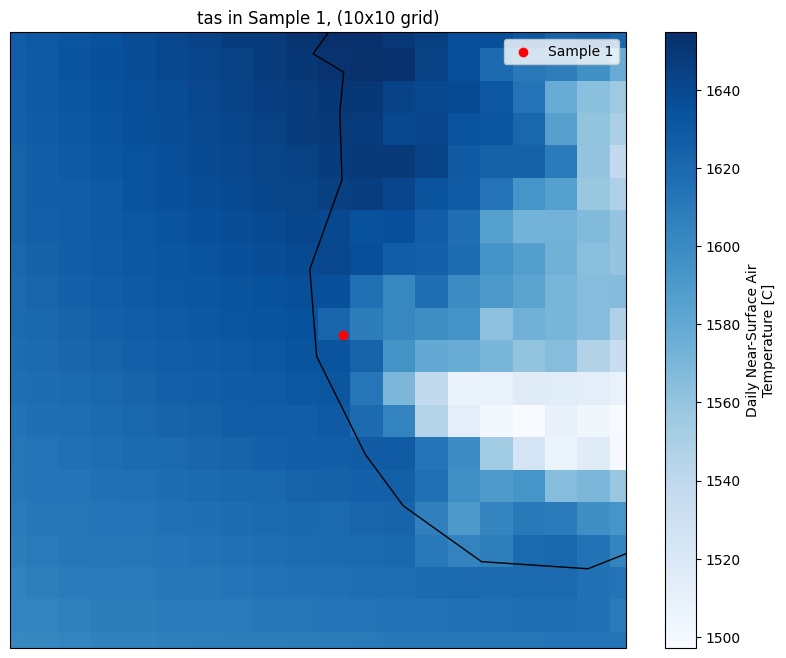

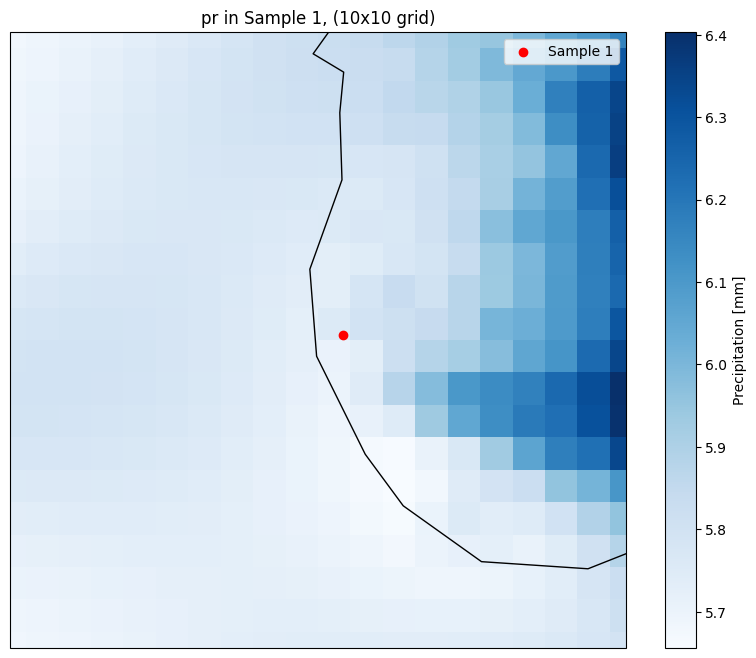

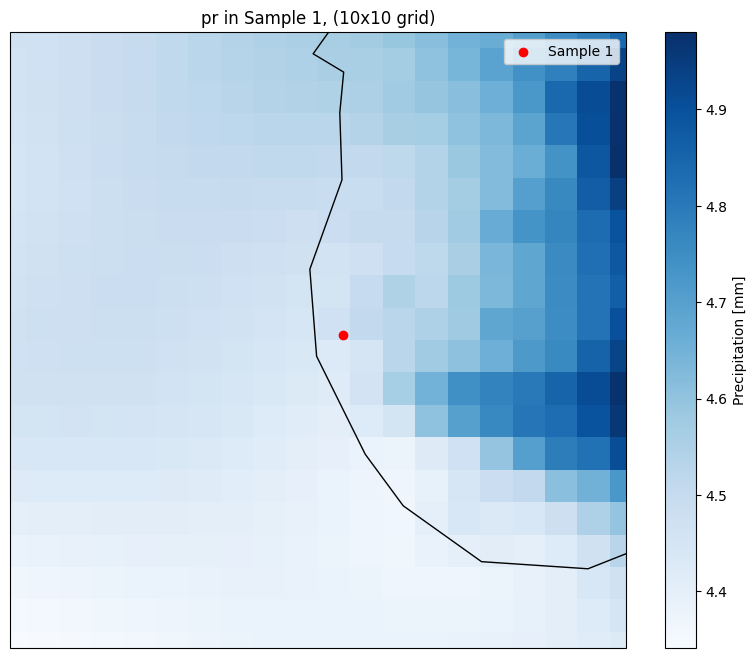

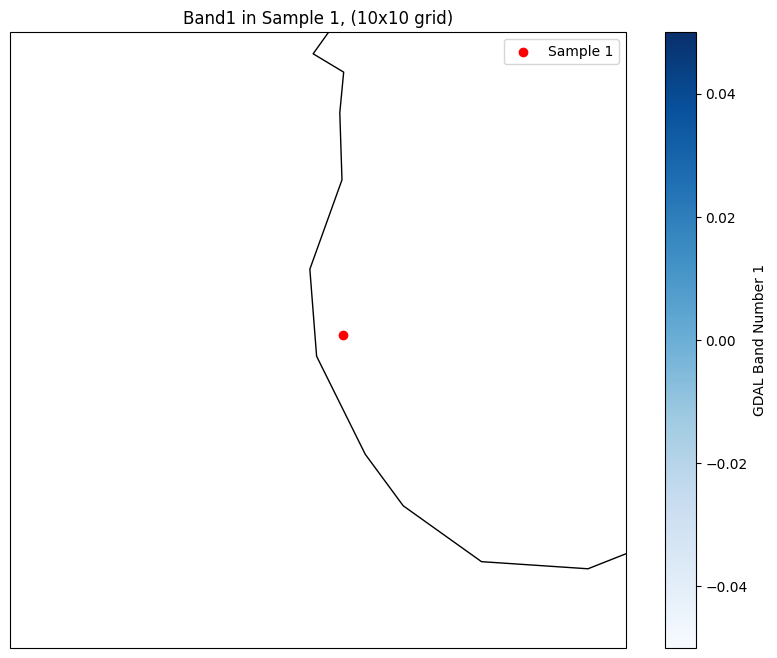

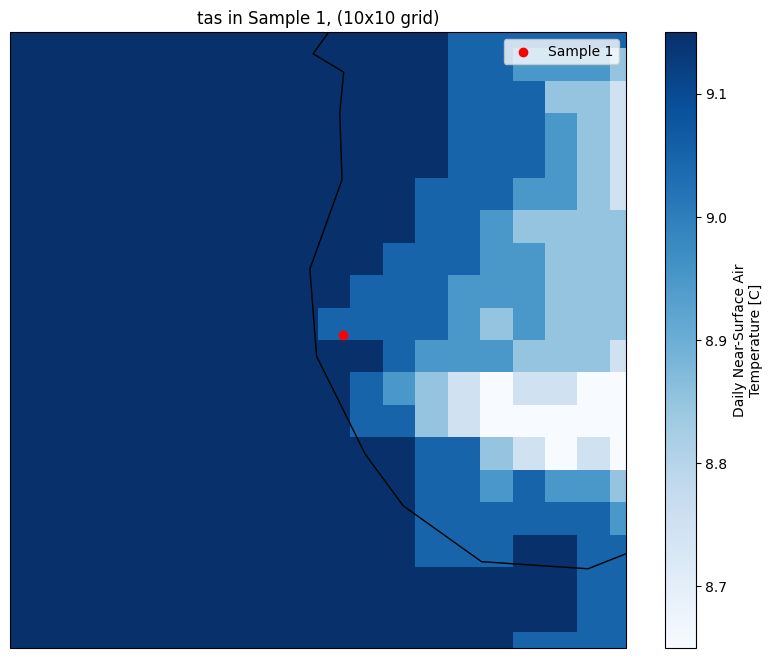

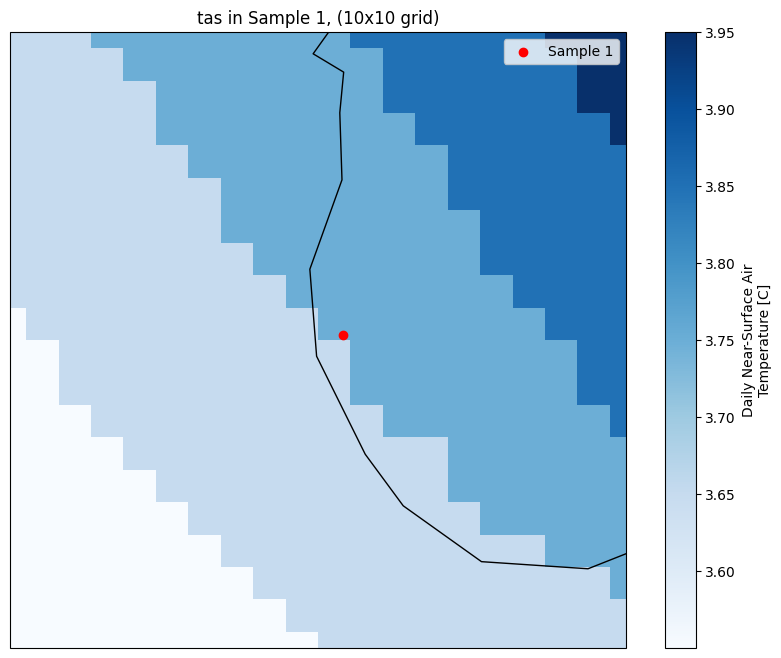

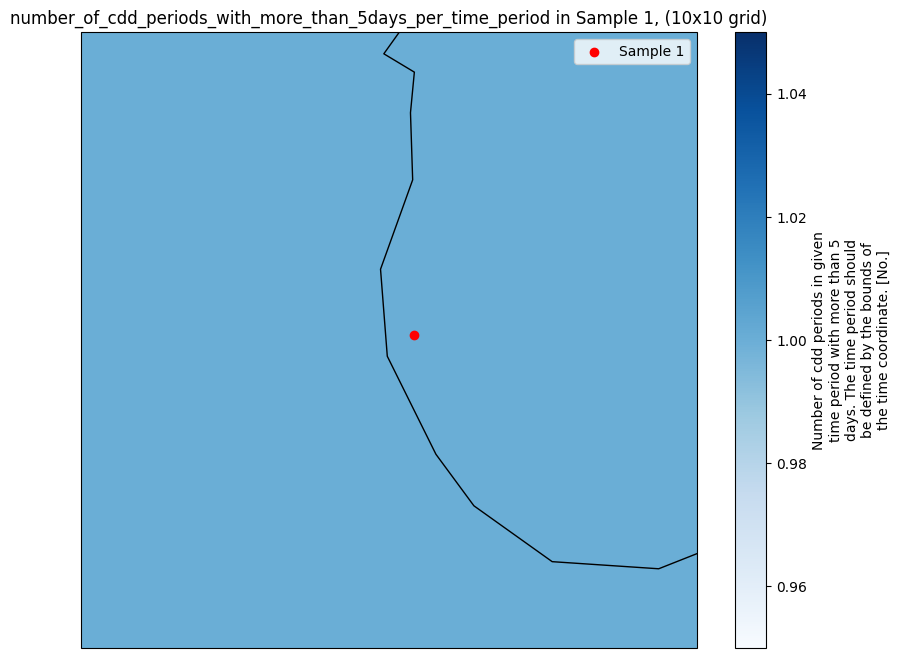

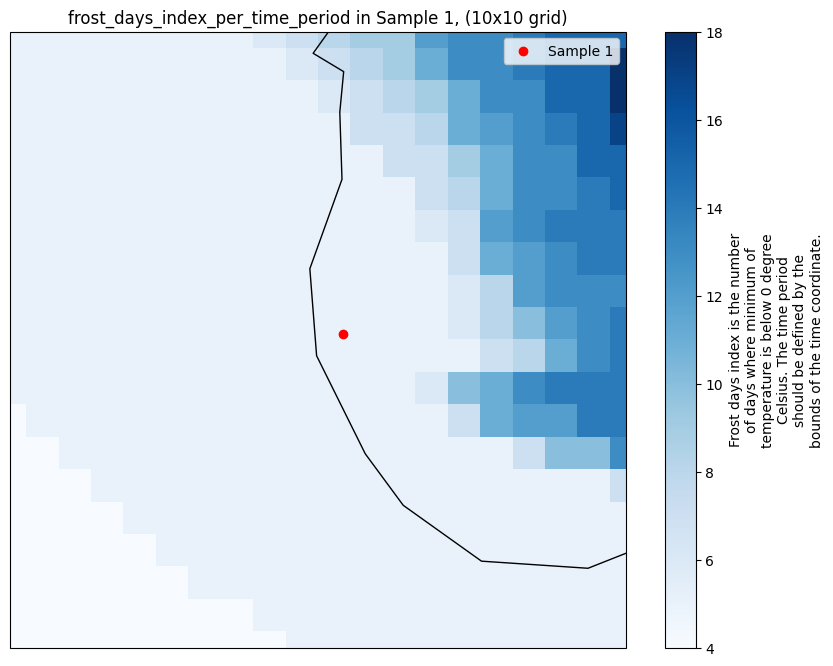

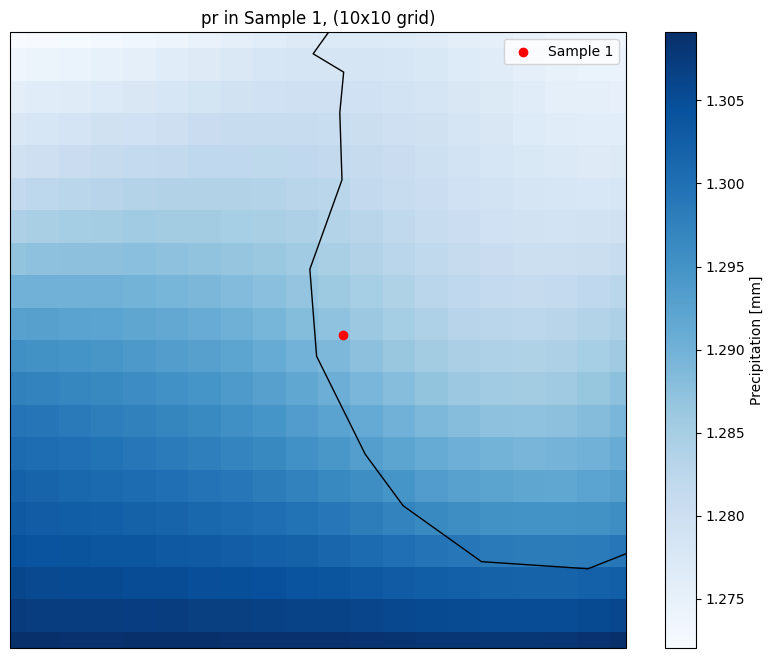

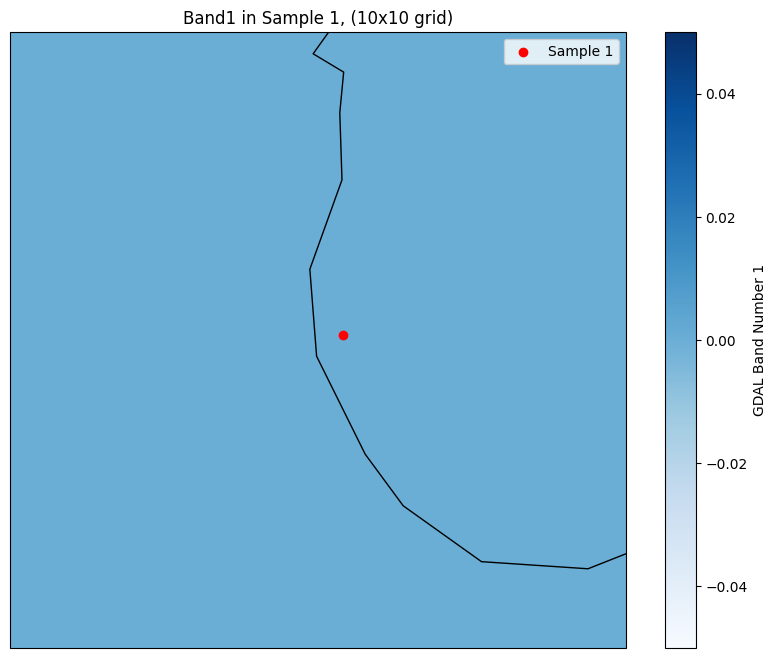

In [13]:
# hay que hacer que de cada sample nos saque las 10 variables climaticas para ese año del fly
# toca inspeccionar manualmente el formato de datos de cada variable y ver si la función sirve para todas
year = '2000'
i = 1

for variable in variables:
    # Define figure and grid layout
    
    dataset = read_netcdf(file_path = CHELSA_path+'/'+variable+f'/CHELSA_EUR11_obs_{variable}_{year}_V.2.1.nc',
                latitude = gbif_assemblages.iloc[0].latitude, #lat of the 1st sample of the dataframe
                longitude = gbif_assemblages.iloc[0].longitude, #lon of the 1st sample of the dataframe
                grid = 10, # grid size (1km scale)
                location = f'Sample {i}') # Title (sample number)


    

### Plotting many samples

PROBLEMA -> La precipitación solo va del 1991 al 2018

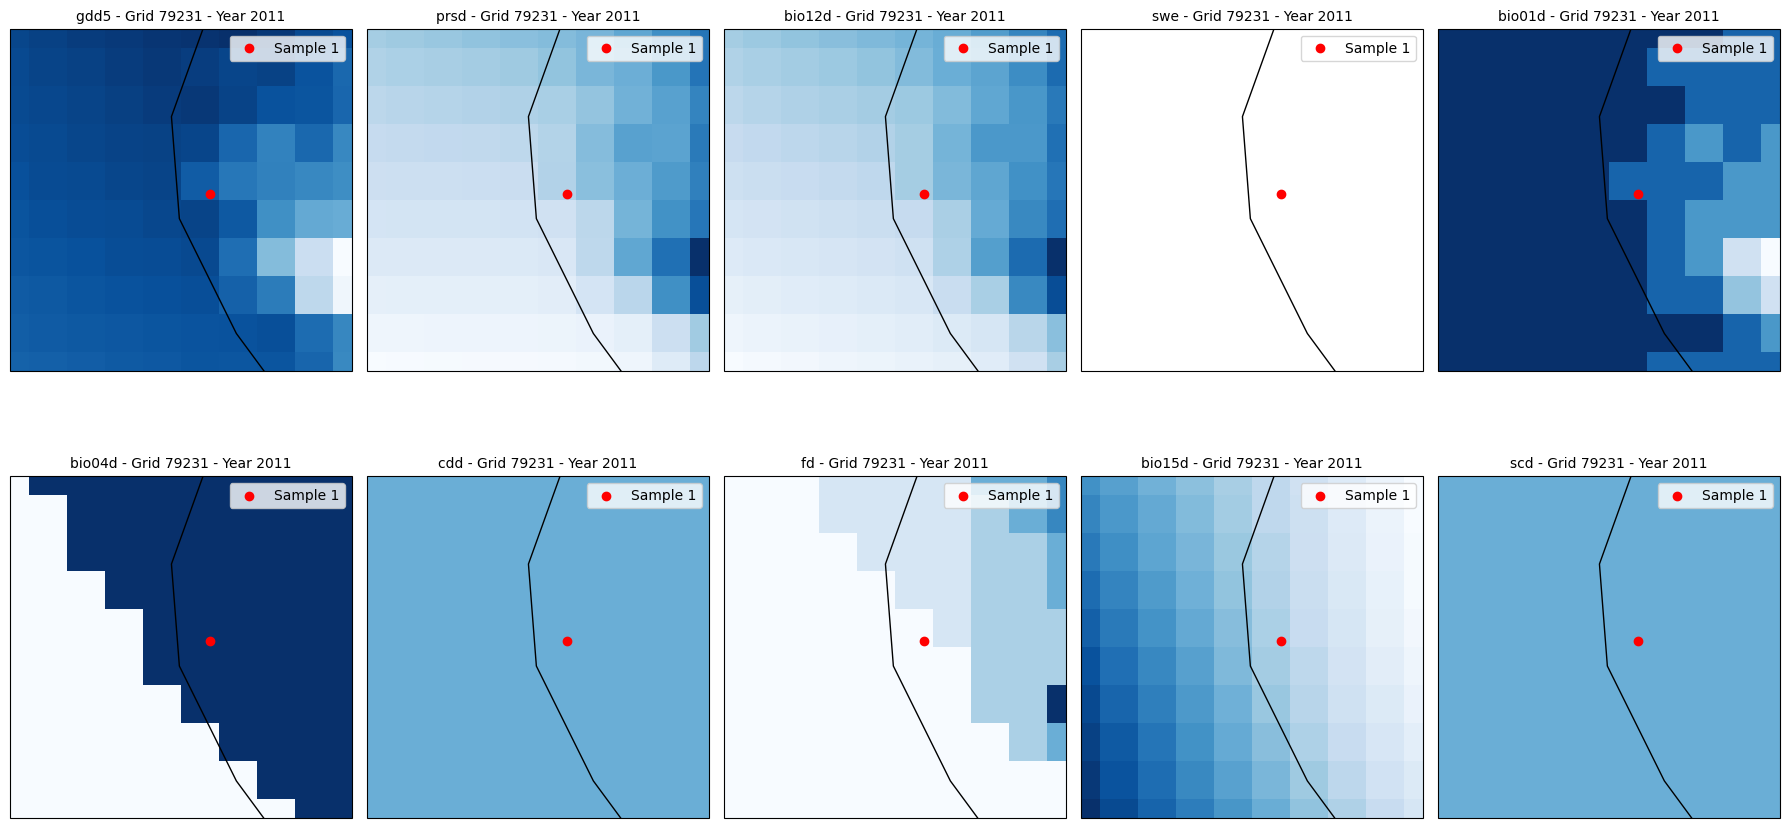

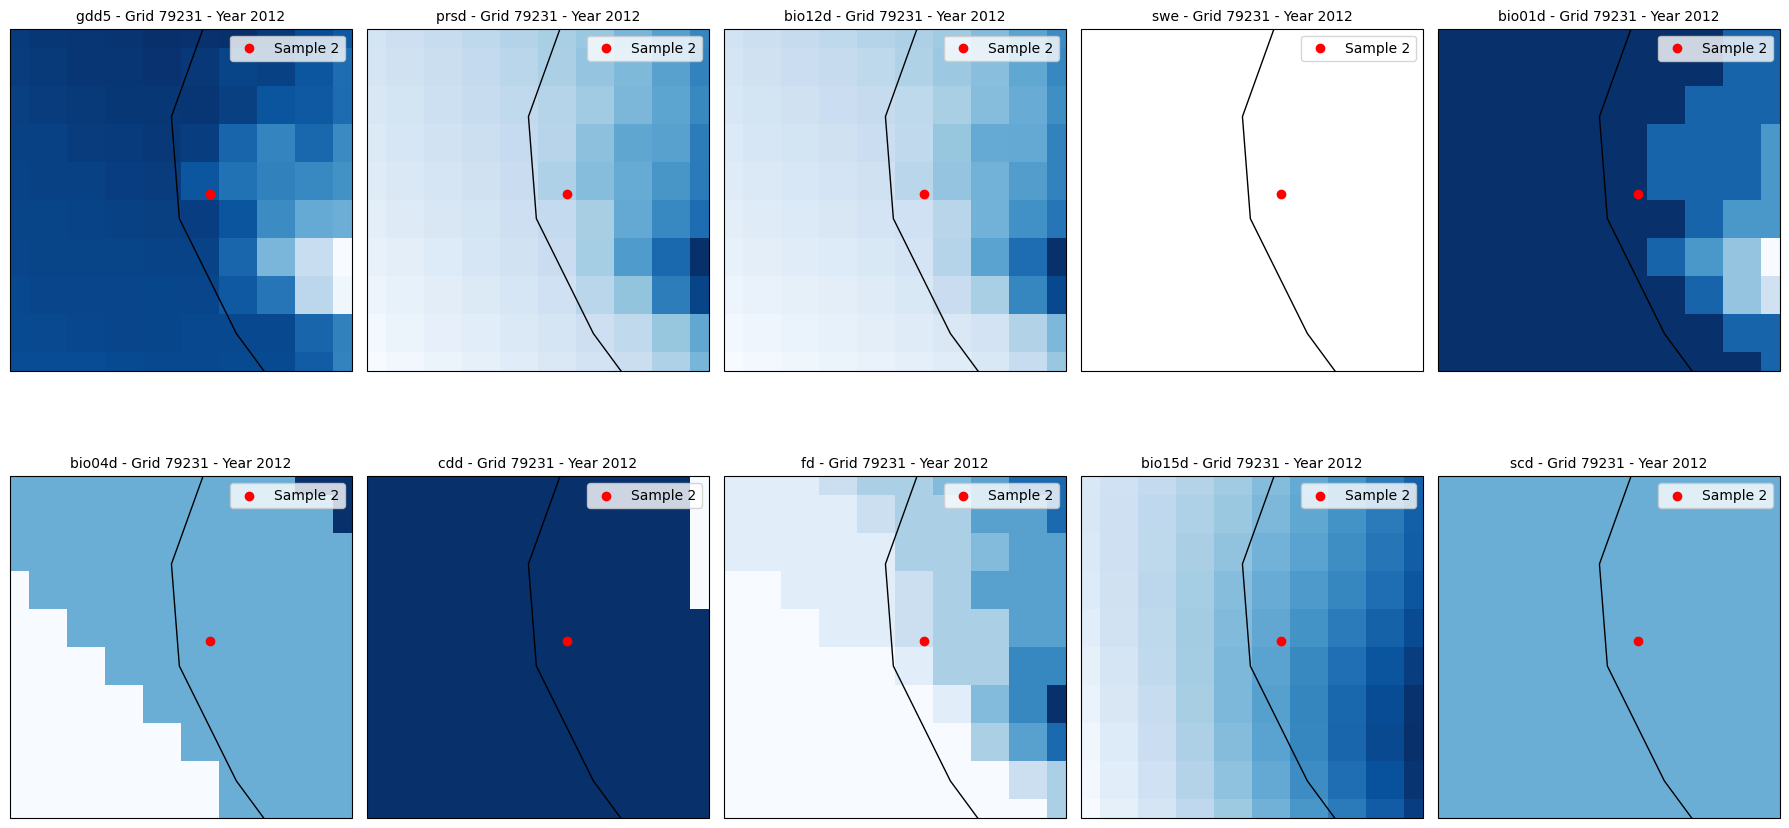

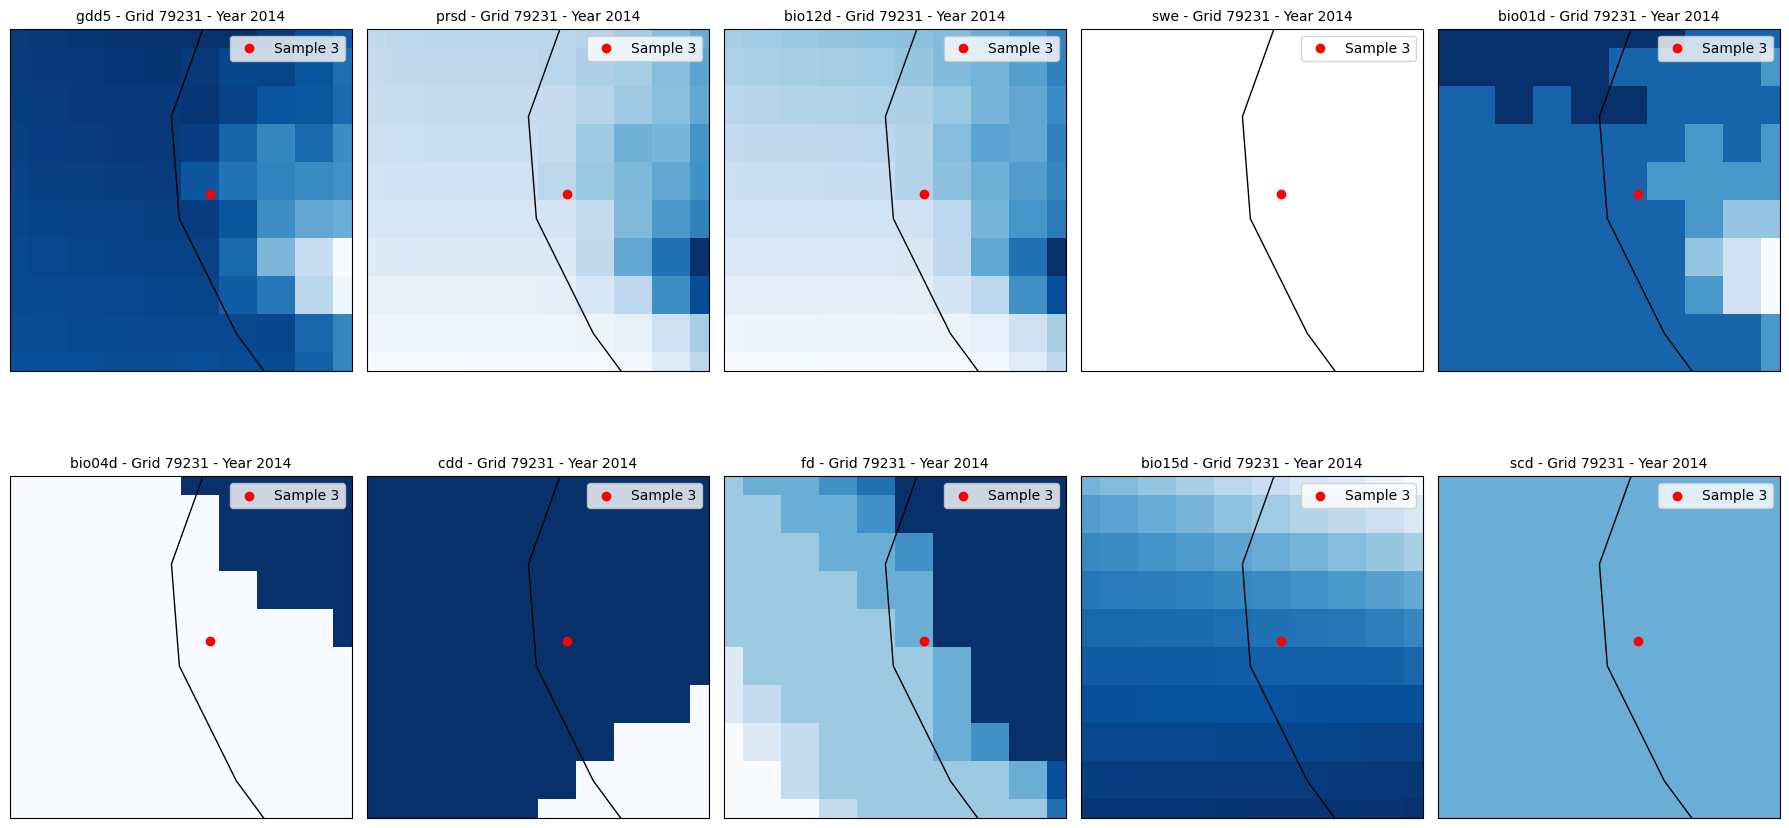

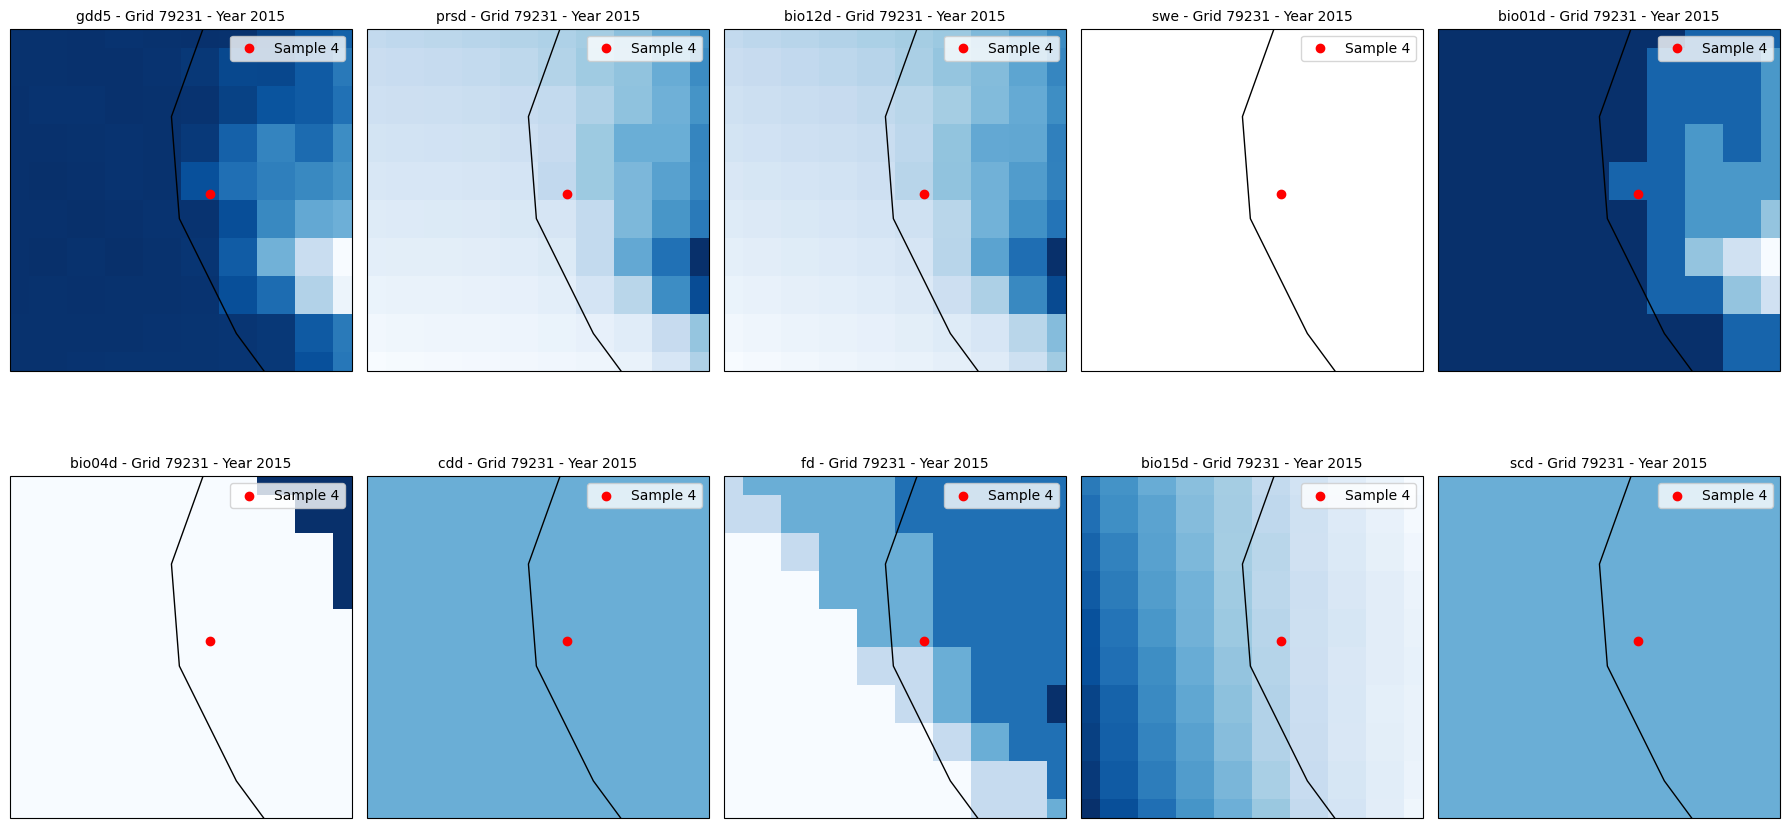

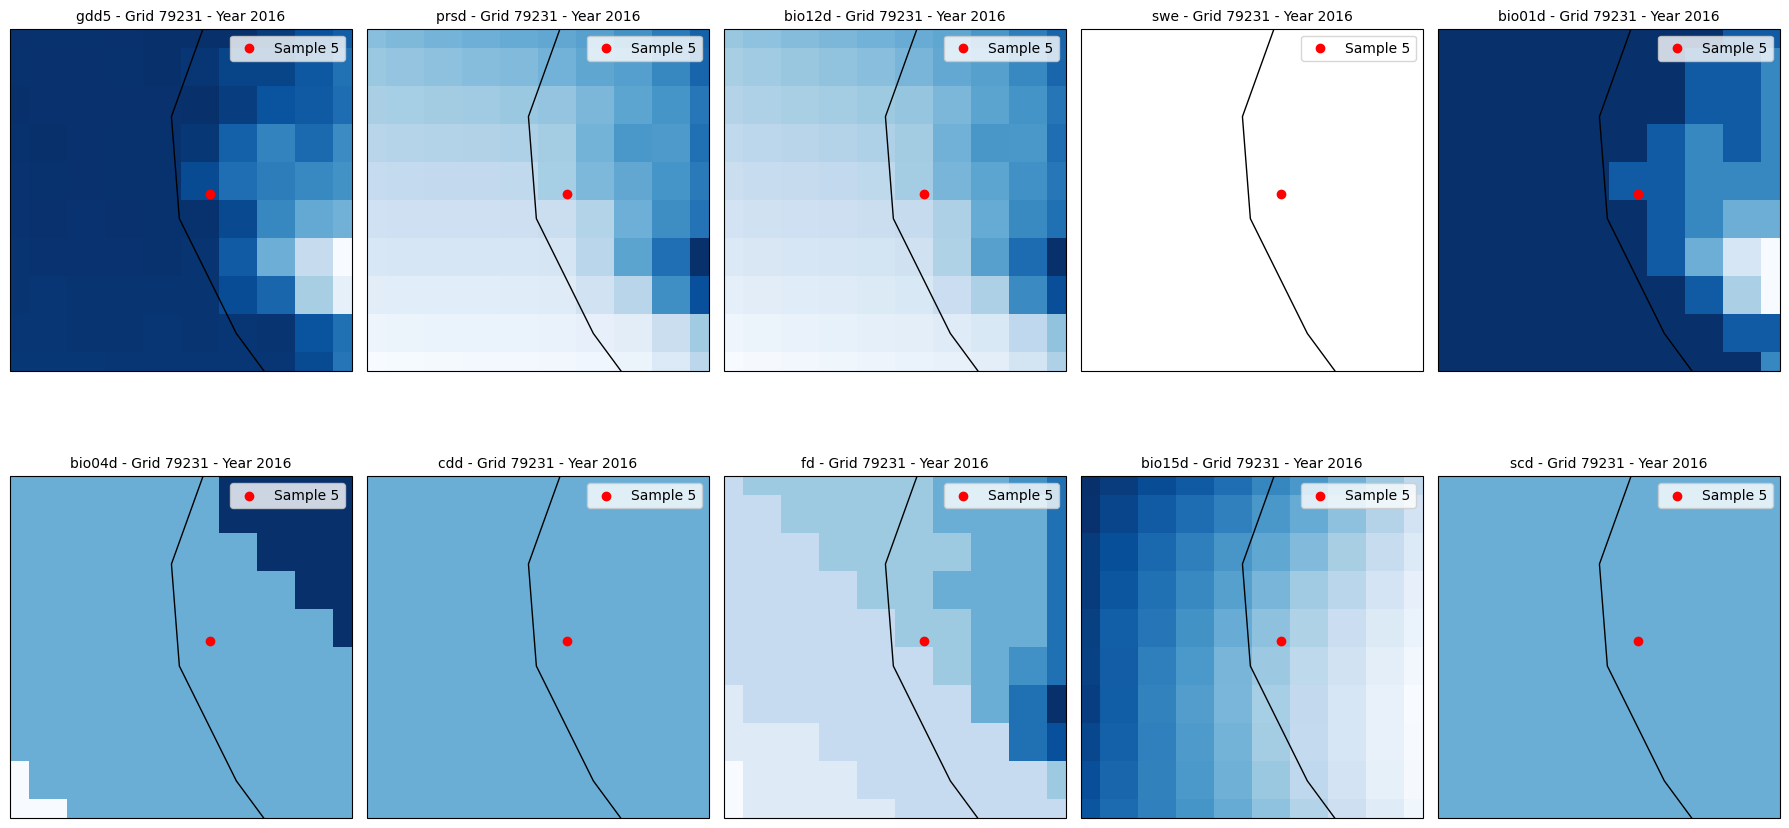

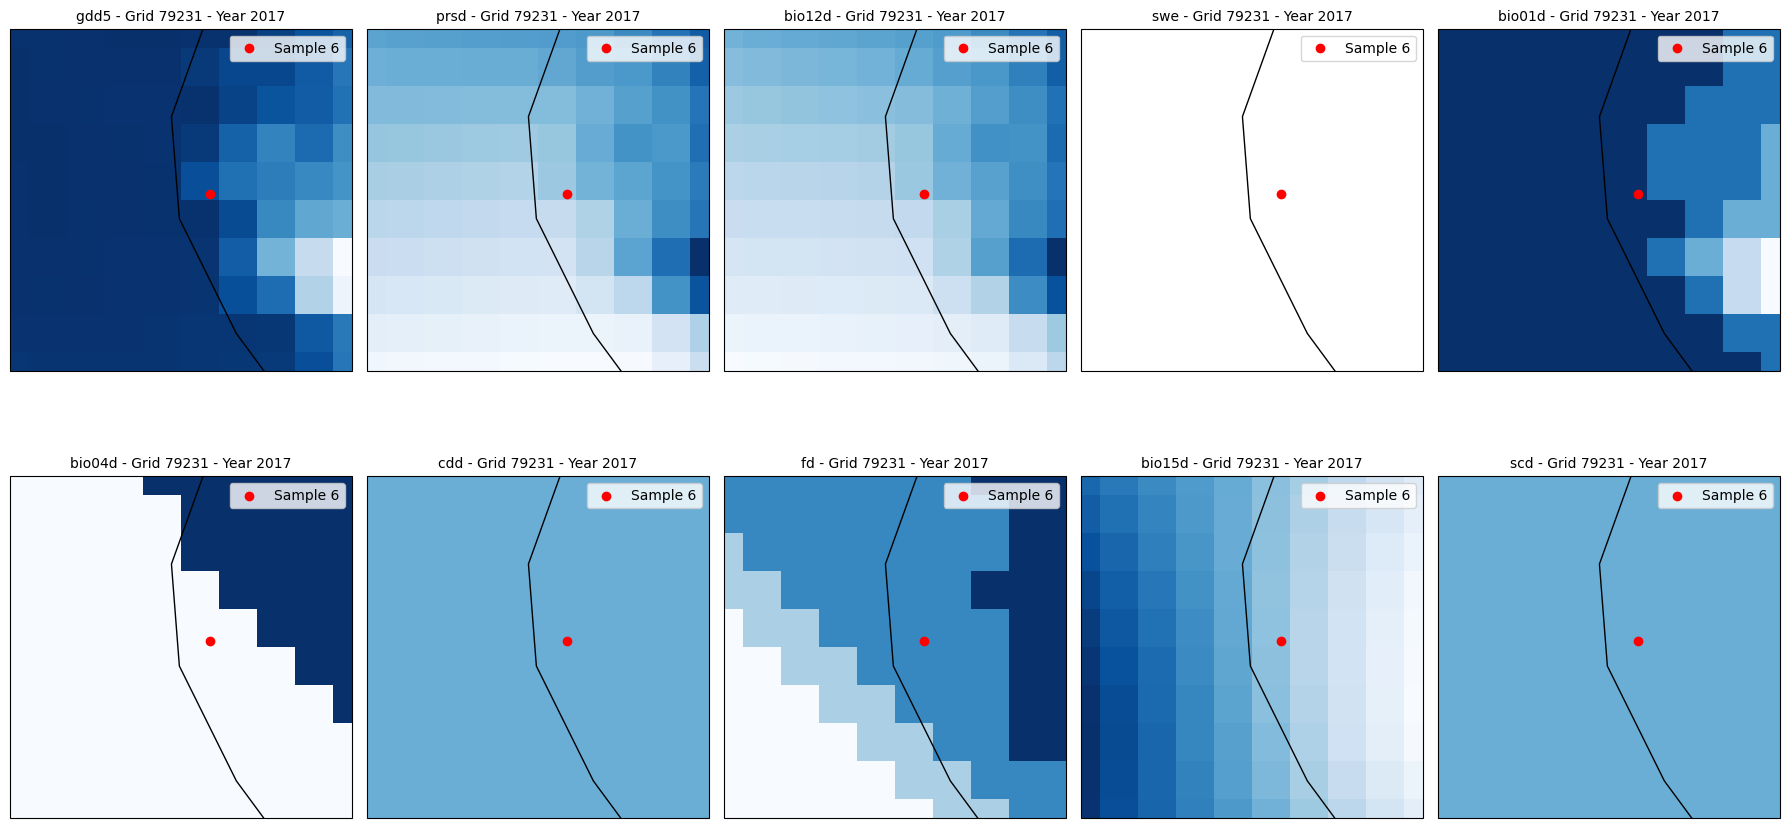

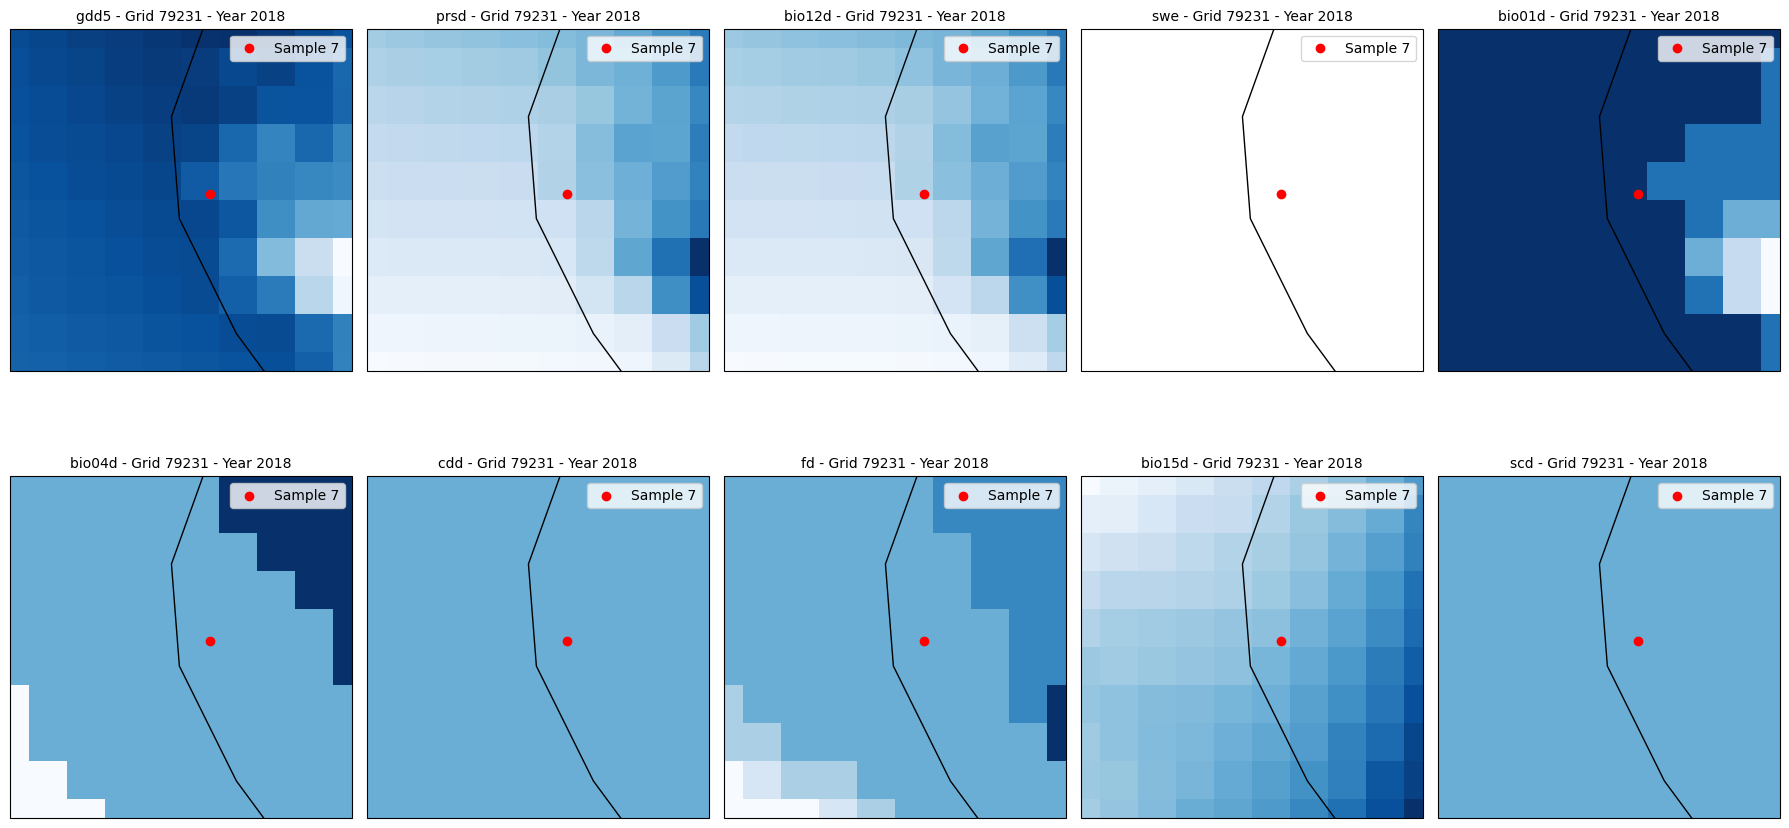

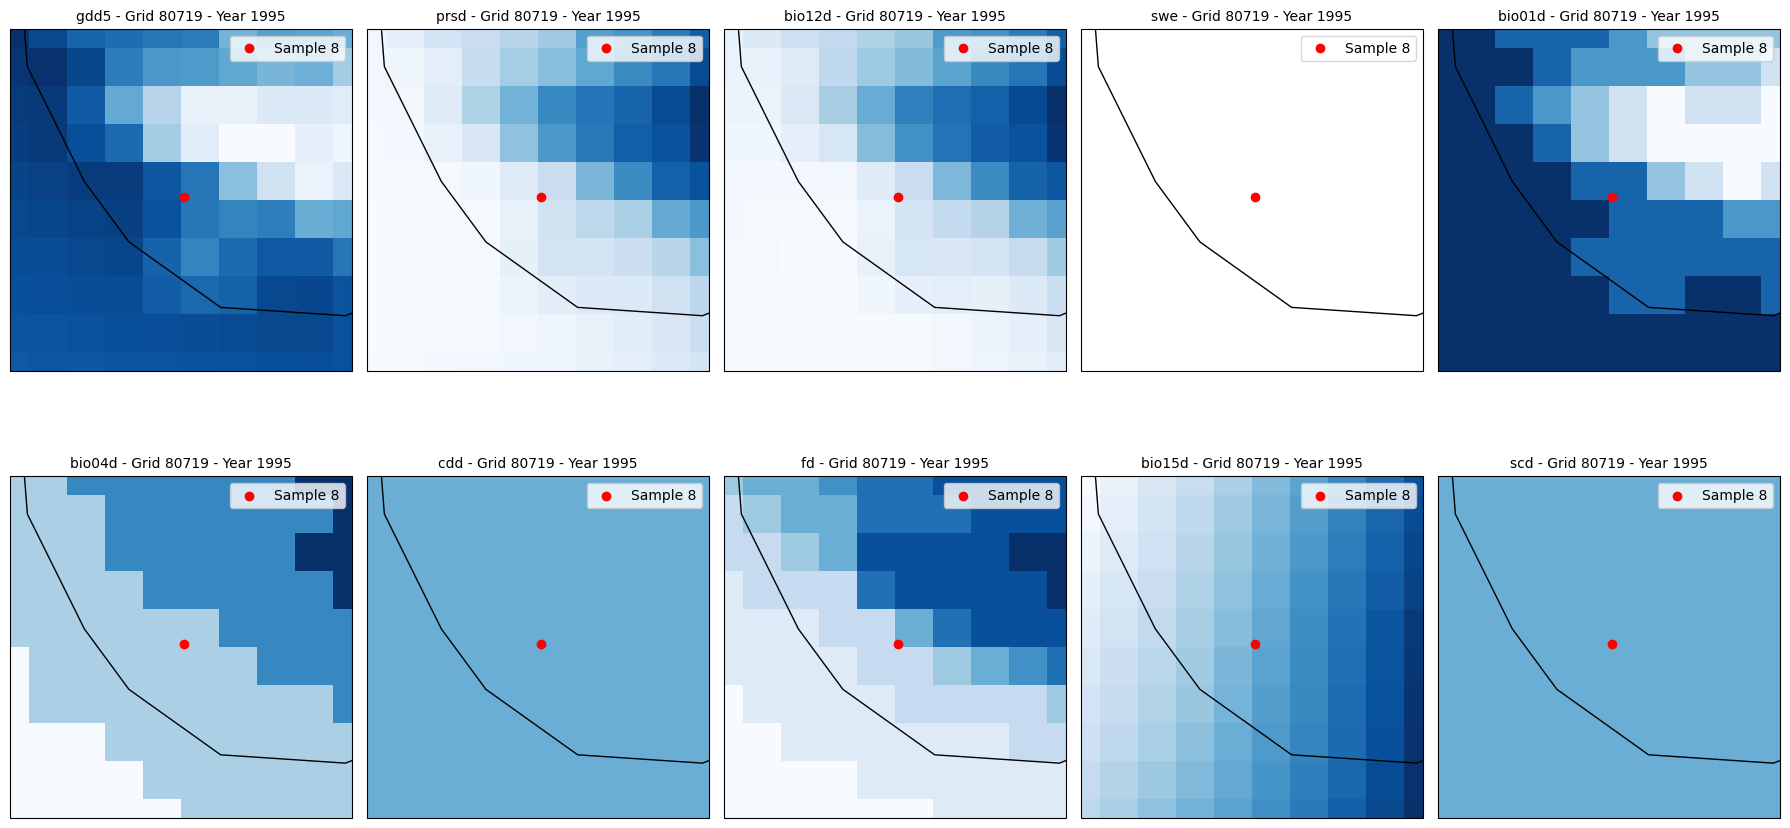

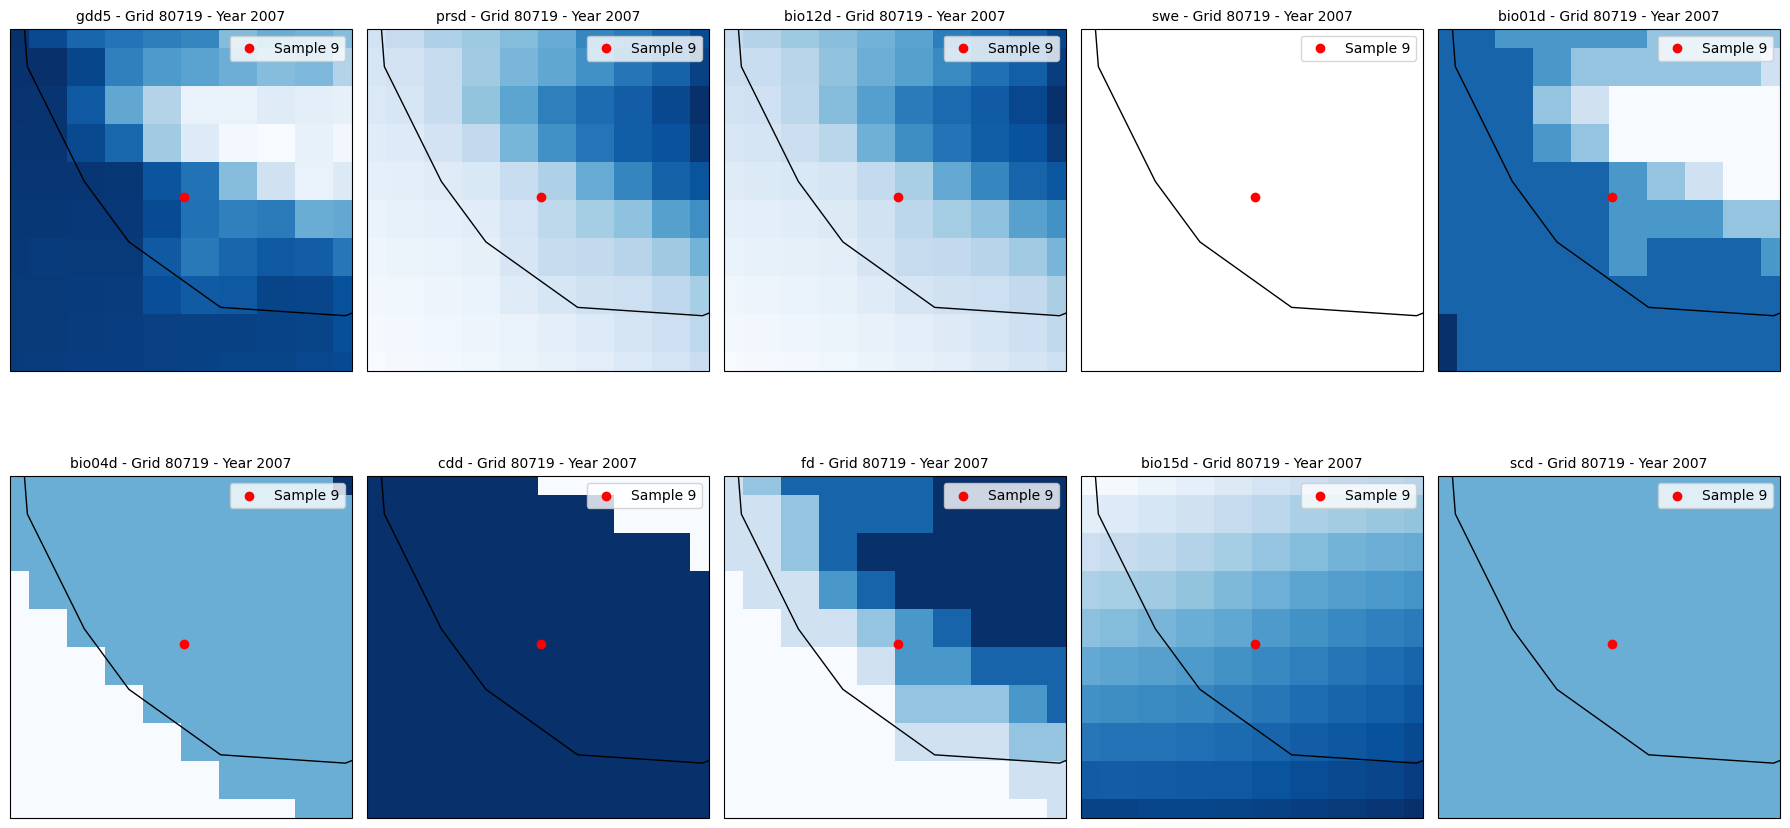

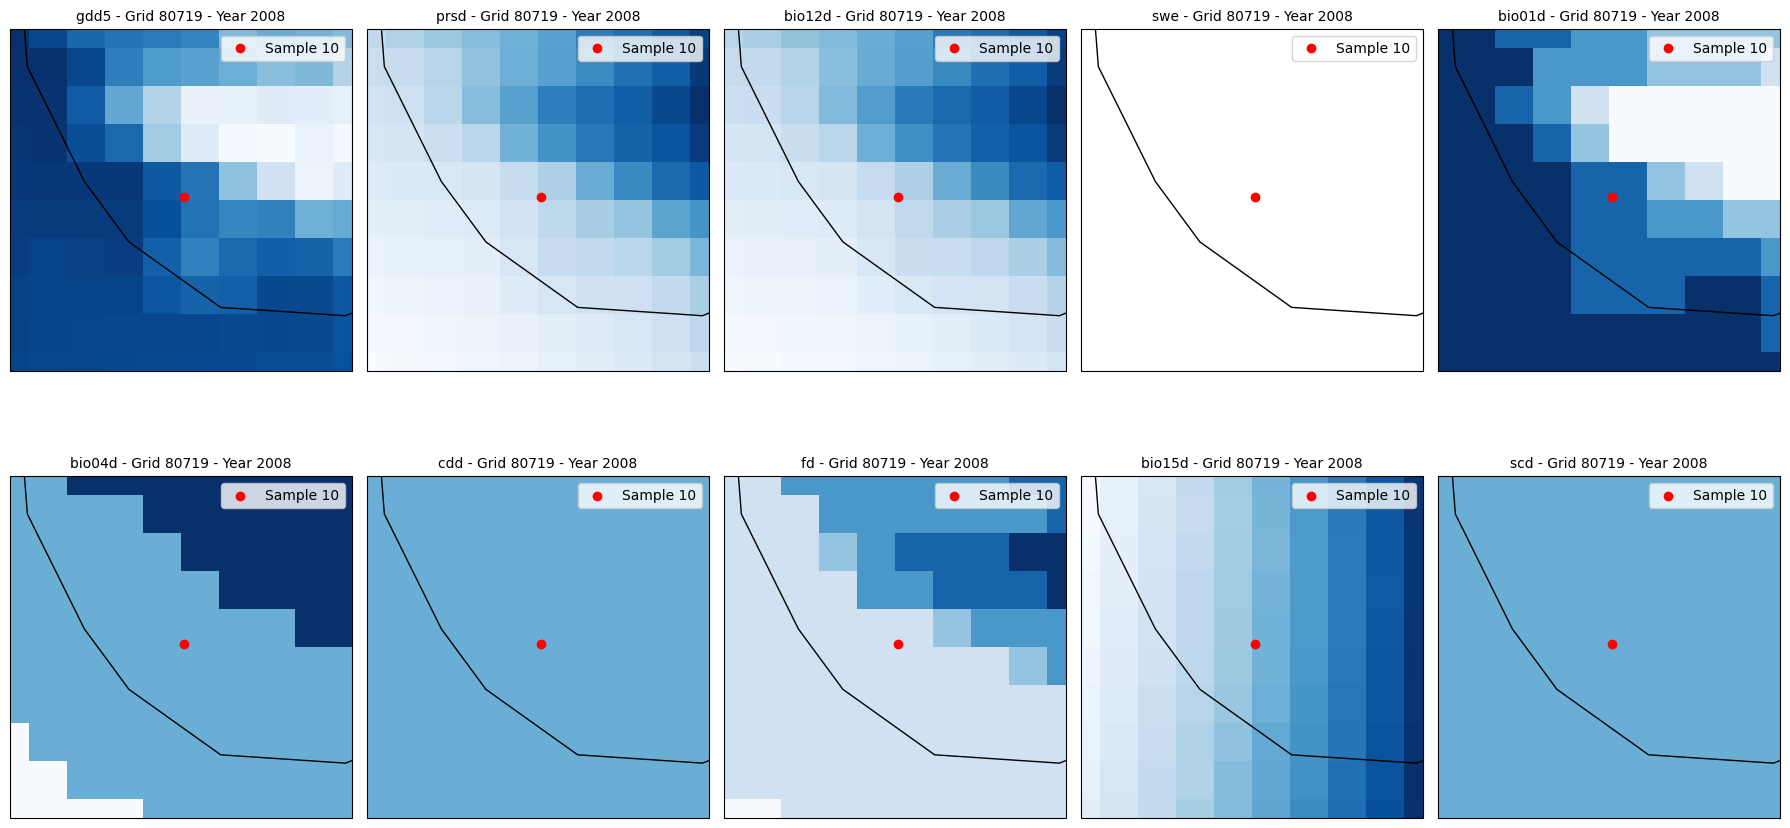

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np

# Function to read and return a NetCDF plot
def read_netcdf_gpt(file_path, latitude, longitude, grid, grid_index, year, sample_number, ax):
    data = xr.open_dataset(file_path)

    # Extract variable name (it is always the last variable)
    variable = list(data.data_vars.keys())[-1]

    # Find the closest grid point
    lat_idx = np.argmin(np.abs(data['lat'].values - latitude))
    lon_idx = np.argmin(np.abs(data['lon'].values - longitude))
    
    # Extract a 10×10 grid
    patch = data[variable].isel(
        lat=slice(lat_idx - grid, lat_idx + grid),
        lon=slice(lon_idx - grid, lon_idx + grid)
    )
    
    # Set title with all requested info
    #ax.set_title(f"{variable} - Sample {sample_number} - Grid {grid_index} - Year {year}", fontsize=10)
    ax.set_extent([patch.lon.min(), patch.lon.max(), patch.lat.min(), patch.lat.max()])
    
    # Plot data
    patch.plot(ax=ax, cmap="Blues", transform=ccrs.PlateCarree(), add_colorbar=False)

    # Add map features
    ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="black")  # Country borders
    ax.add_feature(cfeature.COASTLINE, edgecolor="black")               # Coastline
    
    # Mark sample location
    ax.scatter(longitude, latitude, color="red", label=f"Sample {sample_number}", transform=ccrs.PlateCarree())
    ax.legend()

# Loop through each sample in gbif_assemblages
#year = "2000"
for i, sample in enumerate(gbif_assemblages.head(10).itertuples()):  #change head to adjust the nº of samples
    latitude = sample.latitude
    longitude = sample.longitude
    grid_index = sample.grid_index  # Extract grid index from dataframe
    year = sample.year
    # Create figure and 2x5 grid layout
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    axes = axes.flatten()  # Flatten to iterate easily

    for idx, variable in enumerate(variables):
        if idx >= len(axes):  # Avoid out-of-bounds errors
            break

        # Define file path for the current variable
        file_path = f"{CHELSA_path}/{variable}/CHELSA_EUR11_obs_{variable}_{year}_V.2.1.nc"
        
        # Call `read_netcdf_gpt` and plot on the corresponding subplot
        read_netcdf_gpt(file_path, latitude, longitude, grid=5, grid_index=grid_index, year=year, 
                        sample_number=i+1, ax=axes[idx])
        axes[idx].set_title(f"{variable} - Grid {grid_index} - Year {year}", fontsize=10)

    # Hide unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


### Stacking patches (10 variables stacked in 10 channels)

We are only stacking for 1 sample

In [52]:
import xarray as xr
import numpy as np

def read_netcdf_stack(file_paths, latitude, longitude, grid):
    # Initialize an empty list to store patches (each for a different variable)
    patches = []

    # Loop through each variable's file path
    for file_path in file_paths:
        # Open the NetCDF file for the current variable
        data = xr.open_dataset(file_path)

        # Extract variable name (it is always the last variable)
        variable = list(data.data_vars.keys())[-1]

        # Find the closest grid point
        lat_idx = np.argmin(np.abs(data['lat'].values - latitude))
        lon_idx = np.argmin(np.abs(data['lon'].values - longitude))
        patch = data[variable].isel(
            lat=slice(lat_idx - grid, lat_idx + grid),
            lon=slice(lon_idx - grid, lon_idx + grid)
        )
        # Extract a 10×10 grid patch around the given location
        # if 'time' in data.dims:  # If the variable has a time dimension
        #     patch = data[variable].isel(
        #         lat=slice(lat_idx - grid, lat_idx + grid),
        #         lon=slice(lon_idx - grid, lon_idx + grid)
        #     )
        # else:  # If no time dimension, add a dummy dimension
        #     patch = data[variable].isel(
        #         lat=slice(lat_idx - grid, lat_idx + grid),
        #         lon=slice(lon_idx - grid, lon_idx + grid)
        #     ).expand_dims('time', axis=0)  # Adding dummy time dimension

        # Check the shape of the patch before adding it to the list
        print(f"Shape of patch for {file_path} {variable}: {patch.shape}")
        # we make sure we remove that extra dimension from some samples
        if patch.shape == (1,grid*2,grid*2):
            # Append the patch to the list (convert2 it to numpy array for stacking)
            patches.append(patch.values[0])
        else:
            patches.append(patch.values)


    # Stack all the patches along a new axis (create a multi-channel 3D array)
    stacked_patches = np.stack(patches, axis=-1)  # The last axis represents the channels

    # stacked_patches now has shape (10, 10, 10), where 10x10 is the spatial resolution and 10 is the number of channels
    return stacked_patches


In [53]:

# Example Usage:
# Define the file paths for each variable (you need to have the full paths for each variable)
variables = ['gdd5', 'prsd', 'bio12d', 'swe', 'bio01d', 'bio04d', 'cdd', 'fd', 'bio15d', 'scd']
file_paths = [f"CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/{var}/CHELSA_EUR11_obs_{var}_2000_V.2.1.nc" for var in variables]

latitude = 62.9,
longitude = 8.2,
grid_size = 5  # 10x10 grid bc we substract 5 from lat and 5 from lon

# Call the function to get the stacked patches
stacked_patches = read_netcdf_stack(file_paths, latitude, longitude, grid_size)

# Now stacked_patches is a 3D numpy array with shape (10, 10, 10), representing a 10x10 grid with 10 channels

Shape of patch for CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/gdd5/CHELSA_EUR11_obs_gdd5_2000_V.2.1.nc tas: (1, 10, 10)
Shape of patch for CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/prsd/CHELSA_EUR11_obs_prsd_2000_V.2.1.nc pr: (1, 10, 10)
Shape of patch for CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/bio12d/CHELSA_EUR11_obs_bio12d_2000_V.2.1.nc pr: (1, 10, 10)
Shape of patch for CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/swe/CHELSA_EUR11_obs_swe_2000_V.2.1.nc Band1: (10, 10)
Shape of patch for CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/bio01d/CHELSA_EUR11_obs_bio01d_2000_V.2.1.nc tas: (1, 10, 10)
Shape of patch for CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/bio04d/CHELSA_EUR11_obs_bio04d_2000_V.2.1.nc tas: (1, 10, 10)
Shape of patch for CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/cdd/CHELSA_EUR11_obs_cdd_2000_V.2.1.nc number_of_cdd_periods_with_more_than_5days_per_time_period: (1, 10, 10)
Shape of patch for CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.

In [55]:
len(stacked_patches),len(stacked_patches[0]),len(stacked_patches[0][0])

(10, 10, 10)

In [57]:
stacked_patches.shape

(10, 10, 10)

### Stacking for all samples!!!!!!!!!!!!!!!!!!

In [56]:
gbif_assemblages.head()

,grid_index,year,species,longitude,latitude
1,79231,2011,"['Angelica archangelica', 'Dactylorhiza majali...",5.172939,59.201189
2,79231,2012,"['Carex distans', 'Euphrasia foulaensis', 'Car...",5.172939,59.201189
3,79231,2014,"['Lysimachia europaea', 'Ficaria verna', 'Junc...",5.172939,59.201189
4,79231,2015,"['Tripolium pannonicum', 'Centaurium littorale...",5.172939,59.201189
5,79231,2016,"['Lysimachia europaea', 'Lythrum salicaria', '...",5.172939,59.201189


In [69]:
# Define the file paths for each variable (you need to have the full paths for each variable)
variables = ['gdd5', 'prsd', 'bio12d', 'bio01d', 'bio04d', 'cdd', 'fd', 'bio15d', 'scd'] # 'swe', we have removed it bc it has Nan values in many cases
stacked_patches_list = []
x = 100
for i in range(x): # gbif_assemblages.shape[0]
    sample = gbif_assemblages.iloc[i]
    file_paths = [f"CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/{var}/CHELSA_EUR11_obs_{var}_{sample.year}_V.2.1.nc" for var in variables]
    
    # Call the function to get the stacked patches
    stacked_patches = read_netcdf_stack(file_paths = file_paths, 
                                        latitude = sample.latitude, 
                                        longitude = sample.longitude, 
                                        grid = 5)
    
    stacked_patches_list.append(stacked_patches)

    print(f'Sample {i} correctly stacked and added to the list')
    print('\n\n')

Shape of patch for CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/gdd5/CHELSA_EUR11_obs_gdd5_2011_V.2.1.nc tas: (1, 10, 10)
Shape of patch for CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/prsd/CHELSA_EUR11_obs_prsd_2011_V.2.1.nc pr: (1, 10, 10)
Shape of patch for CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/bio12d/CHELSA_EUR11_obs_bio12d_2011_V.2.1.nc pr: (1, 10, 10)
Shape of patch for CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/bio01d/CHELSA_EUR11_obs_bio01d_2011_V.2.1.nc tas: (1, 10, 10)
Shape of patch for CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/bio04d/CHELSA_EUR11_obs_bio04d_2011_V.2.1.nc tas: (1, 10, 10)
Shape of patch for CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/cdd/CHELSA_EUR11_obs_cdd_2011_V.2.1.nc number_of_cdd_periods_with_more_than_5days_per_time_period: (1, 10, 10)
Shape of patch for CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/fd/CHELSA_EUR11_obs_fd_2011_V.2.1.nc frost_days_index_per_time_period: (1, 10, 10)
Shape of patch for CHELSA/1991-2020/c

In [70]:
stacked_patches_list[1], len(stacked_patches_list[0])

(array([[[1.4091029e+03, 5.6179118e+00, 4.3344536e+00, 8.2500000e+00,
          4.3500061e+00, 1.0000000e+00, 2.3000000e+01, 1.2961061e+00,
          0.0000000e+00],
         [1.4094030e+03, 5.6424718e+00, 4.3454919e+00, 8.2500000e+00,
          4.3500061e+00, 1.0000000e+00, 2.3000000e+01, 1.2984656e+00,
          0.0000000e+00],
         [1.4092029e+03, 5.6661305e+00, 4.3556828e+00, 8.2500000e+00,
          4.3500061e+00, 1.0000000e+00, 2.3000000e+01, 1.3008593e+00,
          0.0000000e+00],
         [1.4104030e+03, 5.6895809e+00, 4.3648634e+00, 8.2500000e+00,
          4.3500061e+00, 1.0000000e+00, 2.3000000e+01, 1.3034958e+00,
          0.0000000e+00],
         [1.4111029e+03, 5.7138610e+00, 4.3738523e+00, 8.2500000e+00,
          4.3500061e+00, 1.0000000e+00, 2.3000000e+01, 1.3063681e+00,
          0.0000000e+00],
         [1.4111029e+03, 5.7399535e+00, 4.3842077e+00, 8.2500000e+00,
          4.3500061e+00, 1.0000000e+00, 2.3000000e+01, 1.3092339e+00,
          0.0000000e+00],
    

In [71]:
len(stacked_patches_list)

100

In [72]:
gbif_assemblages_climatic = gbif_assemblages.head(x)

gbif_assemblages_climatic['climatic_map'] = stacked_patches_list

/tmp/ipykernel_3525/416473453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gbif_assemblages_climatic['climatic_map'] = stacked_patches_list


In [73]:
gbif_assemblages_climatic

,grid_index,year,species,longitude,latitude,climatic_map
1,79231,2011,"['Angelica archangelica', 'Dactylorhiza majali...",5.172939,59.201189,"[[[1631.1528, 5.2400827, 4.2594795, 8.950012, ..."
2,79231,2012,"['Carex distans', 'Euphrasia foulaensis', 'Car...",5.172939,59.201189,"[[[1409.1029, 5.617912, 4.3344536, 8.25, 4.350..."
3,79231,2014,"['Lysimachia europaea', 'Ficaria verna', 'Junc...",5.172939,59.201189,"[[[1850.2533, 5.78069, 3.956082, 9.75, 4.55001..."
4,79231,2015,"['Tripolium pannonicum', 'Centaurium littorale...",5.172939,59.201189,"[[[1585.8533, 4.8328342, 4.133808, 9.150024, 3..."
5,79231,2016,"['Lysimachia europaea', 'Lythrum salicaria', '...",5.172939,59.201189,"[[[1703.103, 4.7999606, 3.2454371, 9.150024, 4..."
...,...,...,...,...,...,...
129,89670,2008,"['Silene flos-cuculi', 'Picea sitchensis', 'Na...",5.306397,59.166089,"[[[1686.4031, 5.2793174, 3.8895628, 9.25, 4.55..."
130,89672,2012,"['Angelica sylvestris', 'Calluna vulgaris', 'E...",5.301337,59.183793,"[[[1396.3029, 6.368, 4.7861476, 8.150024, 4.45..."
131,89672,2013,"['Erica tetralix', 'Sedum anglicum', 'Dactylor...",5.301337,59.183793,"[[[1578.5527, 6.3590593, 4.270548, 8.25, 5.25,..."
132,89672,2018,"['Lonicera periclymenum', 'Rhynchospora alba',...",5.301337,59.183793,"[[[1706.8527, 6.3067937, 3.840493, 8.950012, 5..."


### Visualizing the obtained climatic map

IndexError: index 3 is out of bounds for axis 0 with size 3

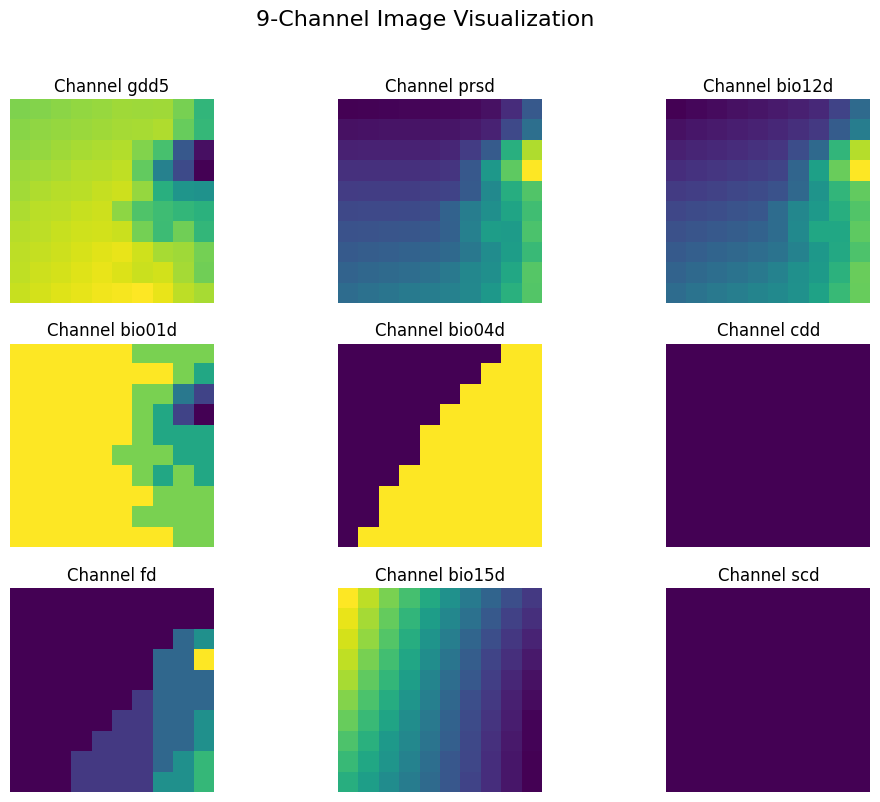

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Example 10-channel image (Replace with your actual data)
image_10ch = gbif_assemblages_climatic.iloc[0].climatic_map  # Shape (Height, Width, 10)

# Set up a 3-row, 3-column grid for 9 channels
fig, axes = plt.subplots(3, 3, figsize=(12, 9))  # Adjust layout for 9 images
fig.suptitle("9-Channel Image Visualization", fontsize=16)

for i in range(10):
    ax = axes[i // 3, i % 3]  # Position in grid
    ax.imshow(image_10ch[:, :, i], cmap="viridis")  # Use a colormap
    ax.set_title(f"Channel {variables[i]}")
    ax.axis("off")  # Hide axes

plt.tight_layout()
plt.show()


### Stacking Tests

In [31]:
def extract_patch(file_path,grid):
    # Open the NetCDF file for the current variable
    data = xr.open_dataset(file_path)

    # Extract variable name (it is always the last variable)
    variable = list(data.data_vars.keys())[-1]

    # Find the closest grid point
    lat_idx = np.argmin(np.abs(data['lat'].values - latitude))
    lon_idx = np.argmin(np.abs(data['lon'].values - longitude))

    # Extract a 10×10 grid patch around the given location
    if 'time' in data.dims:  # If the variable has a time dimension
        patch = data[variable].isel(
            lat=slice(lat_idx - grid, lat_idx + grid),
            lon=slice(lon_idx - grid, lon_idx + grid)
        )
    return patch, patch.values

path_bio15d = f"CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/bio15d/CHELSA_EUR11_obs_bio15d_2000_V.2.1.nc"

patch_bio15d, patch_values_bio15d = extract_patch(path_bio15d,5)
patch_values_bio15d

path_cdd = f"CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/cdd/CHELSA_EUR11_obs_cdd_2000_V.2.1.nc"

patch_cdd, patch_values_cdd = extract_patch(path_cdd,5)
patch_values_cdd


array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

In [46]:
# Stack along a new axis (channel dimension)
stacked = np.stack((patch_values_bio15d, patch_values_cdd), axis=-1)  # Shape will be (2, 2, 3)

print(stacked)


[[[[1.517409  0.       ]
   [1.5242102 0.       ]
   [1.529646  0.       ]
   [1.5339228 0.       ]
   [1.5379182 0.       ]
   [1.5408076 0.       ]
   [1.5429542 0.       ]
   [1.5437044 0.       ]
   [1.5430357 0.       ]
   [1.5411501 0.       ]]

  [[1.5165808 0.       ]
   [1.522617  0.       ]
   [1.5270926 0.       ]
   [1.5306315 0.       ]
   [1.5340323 0.       ]
   [1.5364041 0.       ]
   [1.5380335 0.       ]
   [1.5386919 0.       ]
   [1.538024  0.       ]
   [1.5363181 0.       ]]

  [[1.5150118 0.       ]
   [1.5202619 0.       ]
   [1.523728  0.       ]
   [1.5266107 0.       ]
   [1.5287929 0.       ]
   [1.5306178 0.       ]
   [1.5317837 0.       ]
   [1.5318824 0.       ]
   [1.5313722 0.       ]
   [1.5290873 0.       ]]

  [[1.513228  0.       ]
   [1.5172313 0.       ]
   [1.5202044 0.       ]
   [1.5224459 0.       ]
   [1.5239795 0.       ]
   [1.5250565 0.       ]
   [1.5257722 0.       ]
   [1.5253546 0.       ]
   [1.5242364 0.       ]
   [1.5221795 0.   

In [48]:
print("Shape:", stacked[0].shape)  # Output: (2, 2, 3)

Shape: (10, 10, 2)


In [34]:
import numpy as np

# Define two 2D matrices
A = np.array([[1, 2, 3], 
              [4, 5, 6]])

B = np.array([[7, 8, 9], 
              [10, 11, 12]])

# Stack along a new axis (channel dimension)
stacked = np.stack((A, B), axis=0)  # Shape will be (2, 2, 3)

print(stacked)
print("Shape:", stacked.shape)  # Output: (2, 2, 3)

[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]
Shape: (2, 2, 3)


### Checking SWE

In [65]:
data_swe = xr.open_dataset("CHELSA/1991-2020/chelsav2/EUR11/obs/annual/V2.1/swe/CHELSA_EUR11_obs_swe_2011_V.2.1.nc")
data_swe


<xarray.Dataset> Size: 320MB
Dimensions:  (lat: 6077, lon: 13147)
Coordinates:
  * lat      (lat) float64 49kB 21.97 21.98 21.99 22.0 ... 72.58 72.59 72.6 72.6
  * lon      (lon) float64 105kB -44.64 -44.63 -44.62 -44.61 ... 64.9 64.9 64.91
Data variables:
    crs      |S1 1B ...
    Band1    (lat, lon) float32 320MB ...
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 2.2.3, released 2017/11/20
    history:             Thu Feb 02 16:26:48 2023: GDAL CreateCopy( /storage/...


**Since we got all Nan in this SWE variable shall we remove it or whaaat?**


In [68]:
# Extract variable name (it is always the last variable)
variable = list(data_swe.data_vars.keys())[-1]
grid = 5
latitude = gbif_assemblages_climatic.iloc[0].latitude
longitude = gbif_assemblages_climatic.iloc[0].longitude
# Find the closest grid point
lat_idx = np.argmin(np.abs(data_swe['lat'].values - latitude))
lon_idx = np.argmin(np.abs(data_swe['lon'].values - longitude))
patch = data_swe[variable].isel(
            lat=slice(lat_idx - grid, lat_idx + grid),
            lon=slice(lon_idx - grid, lon_idx + grid)
        )

patch.values

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32)

### Reading images to see stacking

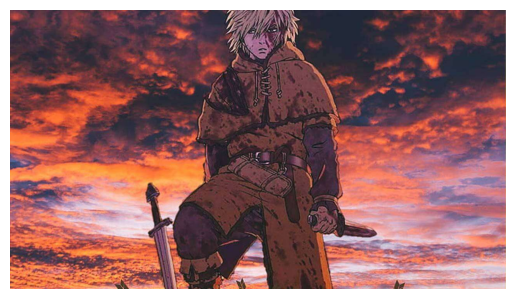

In [35]:
import cv2
# Show the image
# Convert BGR to RGB (since OpenCV loads images in BGR format)
image_rgb = cv2.cvtColor(cv2.imread("/home/raul/Downloads/vinland-saga-2.jpg"), cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis("off")  # Hide axes
plt.show()

In [36]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 

# Load image
image = Image.open("/home/raul/Downloads/vinland-saga-2.jpg")

# Convert to NumPy array
image_matrix = np.array(image)

# Print the matrix structure
print("Matrix shape:", image_matrix.shape)
print("Matrix representation:\n", image_matrix)


Matrix shape: (720, 1280, 3)
Matrix representation:
 [[[105  62  72]
  [105  62  72]
  [107  61  72]
  ...
  [ 71  59  61]
  [ 60  48  50]
  [138 126 128]]

 [[108  62  73]
  [108  62  73]
  [108  62  73]
  ...
  [ 70  58  60]
  [ 59  47  51]
  [137 125 127]]

 [[110  63  73]
  [110  63  73]
  [110  63  73]
  ...
  [ 68  57  61]
  [ 57  46  52]
  [134 123 127]]

 ...

 [[209 118  97]
  [212 120  97]
  [214 120  95]
  ...
  [233 204 190]
  [236 205 184]
  [235 208 179]]

 [[239 139 105]
  [244 141 108]
  [246 142 107]
  ...
  [237 205 190]
  [239 207 184]
  [239 210 180]]

 [[247 141 101]
  [250 144 104]
  [255 146 107]
  ...
  [239 206 191]
  [240 208 183]
  [241 210 181]]]


### The images are represented in 720 columns of 1280 rows (pixels) of 3 values (channels RGB)

In [44]:
len(image_matrix)

720

In [37]:
image_matrix[0],len(image_matrix[0])

(array([[105,  62,  72],
        [105,  62,  72],
        [107,  61,  72],
        ...,
        [ 71,  59,  61],
        [ 60,  48,  50],
        [138, 126, 128]], dtype=uint8),
 1280)

In [38]:
image_matrix[1][0],len(image_matrix[0][0])

(array([108,  62,  73], dtype=uint8), 3)

In [39]:
assert patch_values == stacked_patches[0][8], "Matrices are not equal"



NameError: name 'patch_values' is not defined

In [40]:
stacked_patches[0][0]

array([[1453.1523   ,    5.229132 ,    3.4460928,    2.3060138,
           7.350006 ,    6.350006 ,    0.       ,  107.       ,
           1.517409 ,   21.       ],
       [1326.9022   ,    5.483159 ,    3.597377 ,    2.5101244,
           6.75     ,    6.350006 ,    0.       ,  124.       ,
           1.5242102,   24.       ],
       [1281.4521   ,    5.6504536,    3.6939616,    3.4641833,
           6.5500183,    6.350006 ,    0.       ,  138.       ,
           1.529646 ,   57.       ],
       [1286.2023   ,    5.761347 ,    3.7559562,    3.5280447,
           6.5500183,    6.350006 ,    0.       ,  138.       ,
           1.5339228,   58.       ],
       [1297.5522   ,    5.880016 ,    3.8233607,    3.592968 ,
           6.5500183,    6.350006 ,    0.       ,  138.       ,
           1.5379182,   57.       ],
       [1301.8522   ,    6.023842 ,    3.9095354,    3.700288 ,
           6.5500183,    6.350006 ,    0.       ,  138.       ,
           1.5408076,   57.       ],
       [13

In [42]:
len(stacked_patches)

1

In [197]:
len(stacked_patches)

1

In [43]:
stacked_patches.shape # ta mal, tiene que  ser 10x10x10

(1, 10, 10, 10)

In [49]:
stacked_patches

array([[[[1453.1523   ,    5.229132 ,    3.4460928,    2.3060138,
             7.350006 ,    6.350006 ,    0.       ,  107.       ,
             1.517409 ,   21.       ],
         [1326.9022   ,    5.483159 ,    3.597377 ,    2.5101244,
             6.75     ,    6.350006 ,    0.       ,  124.       ,
             1.5242102,   24.       ],
         [1281.4521   ,    5.6504536,    3.6939616,    3.4641833,
             6.5500183,    6.350006 ,    0.       ,  138.       ,
             1.529646 ,   57.       ],
         [1286.2023   ,    5.761347 ,    3.7559562,    3.5280447,
             6.5500183,    6.350006 ,    0.       ,  138.       ,
             1.5339228,   58.       ],
         [1297.5522   ,    5.880016 ,    3.8233607,    3.592968 ,
             6.5500183,    6.350006 ,    0.       ,  138.       ,
             1.5379182,   57.       ],
         [1301.8522   ,    6.023842 ,    3.9095354,    3.700288 ,
             6.5500183,    6.350006 ,    0.       ,  138.       ,
             